In [129]:
import ast
import numpy as np
from pprint import pprint

from task_decomposition.utils.plotting import visualize_trajectory_decompositions
from task_decomposition.data.groundtruths import GROUND_TRUTH
from task_decomposition.data.gpt_outputs import GPT_OUTPUTS

from transformers import BertTokenizer, BertModel
from scipy.spatial.distance import cosine

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


def calculate_iou(A, B, option):
    """
    Calculate the Intersection over Union (IoU) between two trajectory decompositions.

    Args:
    A (list of dictionaries): The first trajectory decomposition.
    B (list of dictionaries): The second trajectory decomposition.

    Returns:
    float: The IoU value between the two decompositions.
    """
    if option == "steps":
        set_a = set((e["start_step"], e["end_step"]) for e in A)
        set_b = set((e["start_step"], e["end_step"]) for e in B)
    else:
        raise NotImplementedError

    intersection = len(set_a.intersection(set_b))
    union = len(set_a.union(set_b))
    iou = intersection / union if union != 0 else 0.0
    return iou


def get_GPT_subtask_decomposition_from_response(response: str) -> list:
    """ """
    # Isolating the subtask_decomposition list part
    start = response.find('subtask_decomposition = [') + len('subtask_decomposition = [')
    end = response.find(']', start)
    list_str = response[start:end]

    # Converting string representation of list to actual Python list
    subtask_decomposition = ast.literal_eval('[' + list_str + ']')
    return subtask_decomposition

def bert_encode(text):
    inputs = tokenizer(text, return_tensors='pt')
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)[0].detach().numpy()

def compare_description_similarity(A, B):
    embedding1 = bert_encode(A)
    embedding2 = bert_encode(B)
    similarity = 1 - cosine(embedding1, embedding2)
    return round(similarity,2)

def adjust_predicted_to_actual(actual, predicted):
    predicted_adjusted = []

    # Function to calculate overlap between two intervals
    def overlap(a, b):
        return max(0, min(a['end_step'], b['end_step']) - max(a['start_step'], b['start_step']))

    # Function to merge subtasks
    def merge_subtasks(subtasks):
        if not subtasks:
            return None
        # Merge all subtask descriptions with a comma and adjust the start and end steps
        merged = {
            "start_step": min(subtask["start_step"] for subtask in subtasks),
            "end_step": max(subtask["end_step"] for subtask in subtasks),
            "subtask": ", ".join(subtask["subtask"] for subtask in subtasks),
        }
        return merged

    # Iterate over actual subtasks to find the best matching predicted subtasks
    for actual_subtask in actual:
        # Find all predicted subtasks that overlap with the current actual subtask
        overlapping_subtasks = [pred_sub for pred_sub in predicted if overlap(actual_subtask, pred_sub) > 0]

        # Merge overlapping subtasks and add to the adjusted list
        merged_subtask = merge_subtasks(overlapping_subtasks)
        if merged_subtask:
            predicted_adjusted.append(merged_subtask)

    return predicted_adjusted

def merge_predicted_actual(predicted, actual):
    if len(actual) == len(predicted):
        return predicted

    merged = []
    for a_start, a_end, _, _ in actual:
        combined_desc = []
        combined_hier = set()
        p_merged_start = np.inf
        p_merged_end = -np.inf

        for p_start, p_end, p_desc, p_hier in predicted:
            # Check if the majority of the predicted sub-task is within the actual sub-task range
            if (p_start >= a_start and p_end <= a_end) or \
               (p_start < a_start and p_end > a_start and (p_end - a_start) >= (p_end - p_start) / 2) or \
               (p_start < a_end and p_end > a_end and (a_end - p_start) >= (p_end - p_start) / 2):
                combined_desc.append(p_desc)
                combined_hier.add(p_hier)
                p_merged_start = min(p_merged_start, p_start)
                p_merged_end = max(p_merged_end, p_end)

        combined_desc_str = ' '.join(combined_desc)
        combined_hier_tuple = tuple(sorted(combined_hier))

        # Append only if there is any predicted sub-task merged
        if combined_desc:
            merged.append((p_merged_start, p_merged_end, combined_desc_str, combined_hier_tuple))

    return merged

def get_transition_points(A, B):
    """Return the start of subtasks"""
    return [a[0] for a in A], [b[0] for b in B]

def distance_between_points(A,B):
    """Calculate L2 distance between two lists of the same size"""
    assert len(A) == len(B)
    return np.sqrt(np.sum(np.square(np.array(A) - np.array(B))))

def mean_absolute_error(A,B):
    """Calculate mean absolute error between two lists of the same size"""
    assert len(A) == len(B)
    return np.mean(np.abs(np.array(A) - np.array(B)))

def calculate_interval_overlap(interval1, interval2):
    # Find the overlap between two intervals
    start = max(interval1[0], interval2[0])
    end = min(interval1[1], interval2[1])
    if start < end:
        return end - start
    return 0

def calculate_iou_and_f1(actual, predicted):
    actual_intervals = [(a[0], a[1]) for a in actual]
    predicted_intervals = [(p[0], p[1]) for p in predicted]

    # Calculate total intersection and total spans
    total_intersection = 0
    total_actual_span = sum([end - start for start, end in actual_intervals])
    total_predicted_span = sum([end - start for start, end in predicted_intervals])

    # Calculate intersection
    for actual_interval in actual_intervals:
        for predicted_interval in predicted_intervals:
            total_intersection += calculate_interval_overlap(actual_interval, predicted_interval)

    # Calculate union
    total_union = total_actual_span + total_predicted_span - total_intersection

    # Calculate IoU
    iou = total_intersection / total_union if total_union != 0 else 0

    # Calculate precision and recall
    precision = total_intersection / total_predicted_span if total_predicted_span != 0 else 0
    recall = total_intersection / total_actual_span if total_actual_span != 0 else 0

    # Calculate F1 score
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    return iou, f1


In [148]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

def format_string(s: list) -> str:
    """
    Add a newline after every 3 words in the list
    """
    x = s.split(" ")
    s_format = []
    for i in range(len(x)):
        s_format.append(x[i])
        s_format.append("\n") if i % 3 == 0 else None
    return " ".join(s_format)


# Redefine the add_intervals_with_colors function to position the text at the edges
def add_intervals_with_colors(intervals, row, color_map, ax, angle):
    for start, end, description, hierarchy in intervals:
        color = color_map[int(hierarchy)-1]
        rect_width = end - start if end - start > 0 else 1
        rect = mpatches.Rectangle(
            (start, row), rect_width, 0.8, edgecolor="black", facecolor=color
        )
        ax.add_patch(rect)

        # Position the text at the top and bottom edges of the bars
        if row == 1:  # For the top bar, start the text at the top edge
            text_y = row + 0.8
            va = "bottom"
        else:  # For the bottom bar, start the text at the bottom edge
            text_y = row
            va = "top"

        # Place the text at a 45 degree angle for actual and -45 for predicted
        ax.text(
            (start+end) / 2,
            text_y,
            format_string(description),
            ha="left",
            va=va,
            fontsize="large",
            color="black",
            rotation=angle,
            rotation_mode="anchor",
        )


def box_plots(actual, predicted, env, ax=None):
    # Set up the plot again
    fig, ax = plt.subplots(figsize=(14, 4)) if ax is None else (None, ax)
    color_map = ['green', 'blue', 'purple', 'orange', 'red']
    max_hierarchy = max(max([int(a[3]) for a in actual]),max([int(p[3]) for p in predicted] ))
    color_map = color_map[:max_hierarchy]

    # Add actual intervals with color map and angle the text at 45 degrees
    add_intervals_with_colors(actual, 1, color_map, ax, angle=45)

    # Add predicted intervals with color map and angle the text at -45 degrees
    add_intervals_with_colors(predicted, 0, color_map, ax, angle=-45)

    # Set the limits, labels, and title
    ax.set_xlim(-5, max(actual[-1][1], predicted[-1][1])+5)
    ax.set_ylim(-9, 16)
    ax.set_yticks([0.4, 1.4])
    ax.set_yticklabels(["Predicted", "Actual"], fontsize=12)
    ax.set_xlabel("Step Number")
    ax.set_title(f"Actual vs Predicted Intervals for {env}", fontsize=14)

    # Place the legend in the upper right corner
    legend_elements = [
        Line2D([0], [0], color=c, lw=4, label=f"Hierarchy Level: {n+1}")
        for n, c in enumerate(color_map)
    ]
    ax.legend(handles=legend_elements, loc="upper right", bbox_to_anchor=(1, 1), ncol=1)

    # BERT ENCODINGS
    # Calculate the similarity between the predicted and actual descriptions
    for a, p in zip(actual, predicted):
        ax.text(
            (a[0] + a[1]) / 2,
            14,
            compare_description_similarity(a[2], p[2]),
            ha="left",
            fontsize="large",
            color="black",
            rotation_mode="anchor",
        )
    return ax
    # plt.tight_layout()
    # plt.show()

Environment: lift
actual_transition_points: [0, 13, 15], predicted_transition_points: [0, 13, 15]
Distance between transition points: 0.0
Mean absolute error between transition points: 0.0
IOU: 1.0
F1: 1.0
Environment: stack
actual_transition_points: [0, 8, 20, 22, 36, 44, 50, 54], predicted_transition_points: [0, 7, 20, 35, 43, 51, 54, 57]
Distance between transition points: 17.11724276862369
Mean absolute error between transition points: 4.375
IOU: 0.8701298701298701
F1: 0.9305555555555556
Environment: open_door
actual_transition_points: [0, 7, 20, 42], predicted_transition_points: [0, 7, 24, 42]
Distance between transition points: 4.0
Mean absolute error between transition points: 1.0
IOU: 0.8732394366197183
F1: 0.9323308270676691
Environment: picknplace
actual_transition_points: [0, 10, 18, 20, 27], predicted_transition_points: [0, 9, 18, 19, 28]
Distance between transition points: 1.7320508075688772
Mean absolute error between transition points: 0.6
IOU: 0.9491525423728814
F1: 0.9

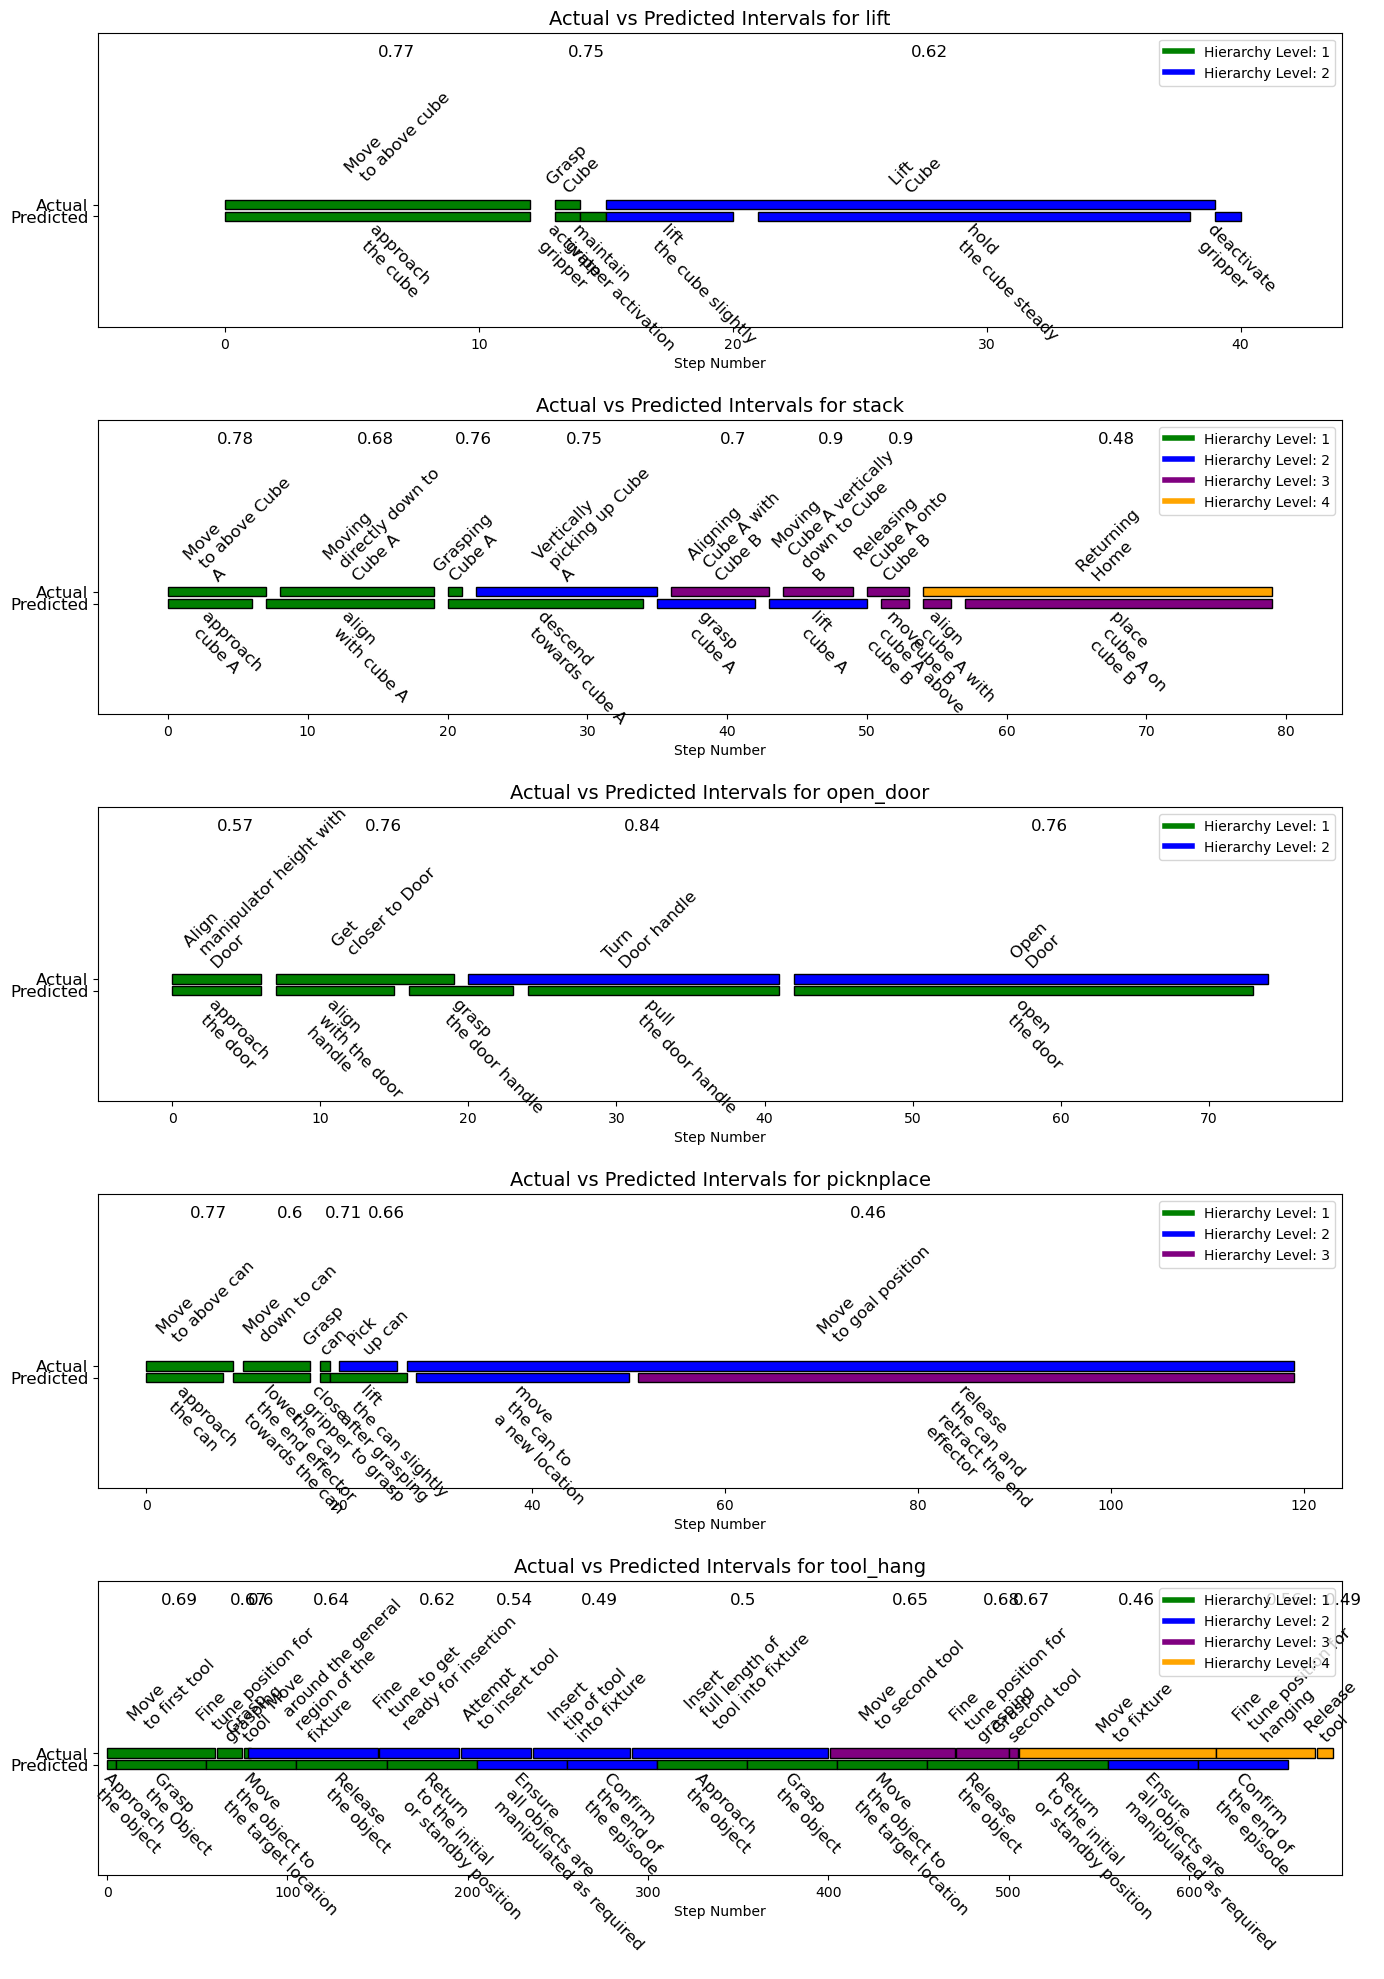

In [149]:
envs = ["lift", "stack", "open_door", "picknplace", "tool_hang"]

n_plots = len(envs)
fig, axs = plt.subplots(n_plots, figsize=(14, 4*n_plots))

for i, env in enumerate(envs):
    print(f"Environment: {env}")
    actual = GROUND_TRUTH[env]
    predicted = GPT_OUTPUTS[env]
    merged_predicted = merge_predicted_actual(predicted, actual)

    ax = box_plots(actual, predicted, env, ax=axs[i])


    actual_transition_points, predicted_transition_points = get_transition_points(actual, merged_predicted)
    print(f"actual_transition_points: {actual_transition_points}, predicted_transition_points: {predicted_transition_points}")
    D = distance_between_points(actual_transition_points, predicted_transition_points)
    M = mean_absolute_error(actual_transition_points, predicted_transition_points)
    print(f"Distance between transition points: {D}")
    print(f"Mean absolute error between transition points: {M}")
    iou, f1 = calculate_iou_and_f1(actual, merged_predicted)
    print(f"IOU: {iou}")
    print(f"F1: {f1}")
    print("====================================")

plt.tight_layout()
plt.show()
